# Bibliographic Networks: A Python Tutorial

Networks can provide significant measures to identify data driven patterns and dependencies. Though, given a data file it can be difficult to discern how one may approach creating such a network. In this tutorial, we will use a bibliographic data file downloaded from a query search in [Scopus](https://https://www.scopus.com/search/form.uri) to walk through the process of cleaning the data file, writing a python script to parse the data into nodes and edges, computing graphical measures using [NetworkX](https://https://networkx.github.io/documentation/stable/index.html), and creating an interactive network display using [HoloViews](https://http://holoviews.org). 

##1. Data Manipulation in Excel

As you are editing and cleaning your data set, be sure to always save in Excel as <i>CSV UTF-8 (Comma delimited) (.csv)</i>. This will ensure that the data file is readable by the Python reader used in this tutorial, and will keep any special characters.

####SCOPUS Specific Data Manipulation
Few SCOPUS downloadable queries are perfect. This tutorial uses the SCOPUS file containing results for the query <i>economics AND "complex systems."</i> Upon downloading this specific data file, some rows are skewed from inaccurate reading and parsing. If you are costumizing this tutorial, simply scroll through the file and delete any rows where the data is clearly mismatched (i.e. an author name in the 'Title' column, a numerical value in a non-numerical column, etc.).


Additionally, across several different queries, we discovered duplicates in entry 'Title,' with other columns containing conflicting data. To fix this issue for the purposes of producing a network, duplicates should be removed. With your .csv file open on Excel, select <i>Data -> Table Tools -> Remove Duplicates</i>. Indicate that the .csv file has headers, as all SCOPUS files will, and only select the 'Title' column by which duplicates will be identified. After executing this command, it is important to save the file as a .csv as previously indicated. Otherwise, Excel may default to saving the file as a .txt, or another format, and data features may be lost. By continuously saving the file as a .csv, we ensure that it will continue to be compatible with the Python code for this tutorial.


Generally, for the case of creating a connected network, we want the rows in our bibliographic data file to have a unique title and a list of references. Other customizations can be made as long as this feature is preserved. 

##**2. Coding Environment**
While we originally developed this script in a local notebook, we found that running it through Google's cloud-based Jupyter notebook environment [Colaboratory](https://colab.research.google.com/) is smoother for general use. Colaboratory allows you to use and share Jupyter notebooks from your browser, without having to download, install, or run anything on your own computer. Notebooks can be saved to your Google Drive, Github or downloaded locally. Learn more about Colab [here](https://research.google.com/colaboratory/faq.html). You can run this notebook in Colaboratory by clicking this icon at the top of the notebook, downlading the notebook and importing it to Colaboratory manually, or downloading the notebook to run locally. 


### Import Necessary Libraries and Packages 
The following code will import and install the necessary libraries and packages for this tutorial into your Colaboratory environment or your local computing environment, if using.



In [0]:
!pip install networkx -q
!pip install numpy -q
!pip install pandas -q
!pip install holoviews -q
!pip install bokeh -q
!pip install scikit-image -q
!pip install xarray -q
!pip install datashader -q
!pip install IPython -q

# To use Colaboratory w/ Google Drive
!pip install -U -q PyDrive


In [0]:
!pip install bokeh==1.1.0

In [0]:
import csv, os
import networkx as nx
import numpy as np
import pandas as pd
import holoviews as hv
from holoviews import opts 
from holoviews.operation.datashader import datashade, bundle_graph
from networkx.algorithms import community

# To use Colaboratory w/ Google Drive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials


from IPython.display import display_html
from bokeh.plotting import figure, output_file, show
from bokeh.models.renderers import GlyphRenderer
from holoviews.plotting.bokeh import BokehRenderer
#import holoviews.plotting.bokeh


The first time you run the notebook in Colaboratory, you will have to authenticate and create the PyDrive client:

In [0]:
# This only needs to be done once per notebook.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

###Insert your own file
To customize this tutorial, decalare your own *.csv* file. If running in Colaboratory, put the *.csv* in your Google Drive and paste the File Name and File ID below. To find the File ID: upload the file to Google Drive, click "get sharable link." The File ID is in the URL. 

> Example: https://drive.google.com/open?id=laggVyWshwcyP6kEI-y_W3P8D26sz

> The File ID in this case is: *laggVyWshwcyP6kEI-y_W3P8D26sz*

Alternatively, learn how to import data from GitHub [here](https://https://medium.com/@yuraist/how-to-upload-your-own-dataset-into-google-colab-e228727c87e9). 


You can't permanently store a file on colab. Though you can import files from your drive and everytime when you are done with file you can save it back.

In [0]:
file_name = 'scopus.csv' # TODO: insert filename
file_id = "11cD94WgWFUpBhQry2uj0HHnpEjXpafrC" # TODO: insert file id in quotes

In [0]:
downloaded = drive.CreateFile({'id': file_id})
downloaded.GetContentFile(file_name)

In [41]:
data = pd.read_csv(file_name) 
print(len(data))

1213


## 3. Partitioning the Data into Nodes and Edges


This Python script is specific to SCOPUS and bibliometric data, though could be easily customized to match the parameters of any data file.

To make a network, we must identify objects and relationships between objects. With bibliometric data, we can identify titles and designate a connection between titles if one is referenceing the other. The downloaded Scopus file identifies a title for a source in each row. The column 'References' indicates a semicolon delimited list of references in MLA or APA format. To make this information useful, we must parse an identifying title from each reference in the list. Because the Scopus file does not maintain consistent formatting accross references, we simply keep the entire reference and search for strings inside strings, though this could be customized depending on data file formatting.

In [0]:
''' 
Requires: 'n_type' is either 'title' or 'reference' 
Modifies: If 'node' occurs in the list, preserves type 'title,' changing either 
          the 'node_list' value and the 'type_dict' type, or just the 'node' value.
          Else, adds 'node' to 'node_list.'
Effects:  Compares 'node' to the current 'note_list.' 
'''
def comp_add(node_list, node, n_type):
    for i in range(len(node_list)): 
        # check to see if 'node' compares to any current nodes
        if node in node_list[i] or node_list[i] in node: 
            # if a node exists as a row 'title' and a row 'reference', 
            # we want to favor the type 'title' in our data structures 
            if n_type == 'title': 
                # switch the representation in 'node_list' to 'title'
                node_list[i] = node
                type_dict[node] = n_type 
            else:
                # switch the representation of 'node' to 'title' 
                node = node_list[i]
            return node 
        
    # the rest of this function executes if 'node' is not already in 'node_list'
    if n_type == 'title':
        node_list.append(node)
        type_dict[node] = n_type
    else: 
        node_list.append(node)
        type_dict[node] = n_type

    return node

The following is the main loop to parse data into nodes and edges. 

In [0]:
len(data)

In [42]:
node_list = [] # a list of titles and references
edge_list = [] # includes rows of format [a, b] where 'a' references 'b'
type_dict = {} # key: node, value: type ('title' or 'reference'), holds all possible node values

row_count = 0
for i, row in data.iterrows():
  # add node with unique identifier
  source_node = row['Title']
  print(source_node)
  source_node = comp_add(node_list, source_node, 'title')
  # add an edge for each source and its references
  # check that references exist
  if type(row['References']) == str:
    row_count += 1
    # add an edge for each source and its references
    refs = row['References'].split(';')
    for ref in refs:
        # disregard web references, and clean data for any formatting inconsistencies
        if 'https://' not in ref and 'http://' not in ref and ref != " " and ref != "":  
            ref = comp_add(node_list, ref, 'reference')
            edge = [source_node, ref] # 'source_node' references 'ref'
            edge_list.append(edge)
            
print(row_count)
#   print(row.Title,"\n\n", row.References, "\n\n", "\n\n")

Emergy evaluation for decision-making in complex multifunctional farming systems
Lagged correlation-based deep learning for directional trend change prediction in financial time series
Control of complex sociotechnical systems: Importance of causal models and game theory
Towards ranking the water-energy-food-land use-climate nexus interlinkages for building a nexus conceptual model with a Heuristic Algorithm
A holonic framework for managing the sustainable supply chain in emerging economies with smart connected metabolism
Complex network approaches to nonlinear time series analysis
Stability of democracies: A complex systems perspective
Assessing sustainability of urbanization by a coordinated development index for an Urbanization-Resources-Environment complex system: A case study of Jing-Jin-Ji region, China
Modelling and simulation of large and complex systems for airport baggage handling security
Conceptualizing carbon emissions from energy utilization in Indonesia's industrial sect

TypeError: ignored

In [43]:
len(edge_list)

31947

## 4. Graph Manipulation
Once you have created an <i>edge_list</i> variable, edges can be added to an NetworkX graph. Using NetworkX for this graph manipulation is intuitive and clean, requiring minimal lines of code. We use a directed graph so that we can determine the frequency by which a node is being referenced, as opposed to the frequency by which a node is referencing.

In [44]:
G = nx.DiGraph()
for n in node_list: 
    G.add_node(n)
G.add_edges_from(edge_list)

'''
G = nx.DiGraph()
for i, n in enumerate(node_list):
  if i % 100 == 0: 
    print(i)
  else:
    pass
  G.add_node(n)
G.add_edges_from(edge_list)
'''

'\nG = nx.DiGraph()\nfor i, n in enumerate(node_list):\n  if i % 100 == 0: \n    print(i)\n  else:\n    pass\n  G.add_node(n)\nG.add_edges_from(edge_list)\n'

For a large graph, depending on the information being represented, one may want to prune the graph to only contain nodes with a degree (the number of connections to a single node) greater than 1. For this bibliometric data, we are primarily interested in the connections between nodes, therefore a node with only one connection is of much less importance. Furthermore, by removing less significant nodes, we can decrease the graph size significantly, creating a more easily understood graphical layout. Be careful to run this code only as many times as you wish to reduce the graph, or else significant information may be lost as the graph is pruned, depending on the degree of interest in the information.

In [0]:
# by running this code once, all isolated subgraphs will be removed 

# first remove nodes of degree 1
nodes_to_remove = []
for n in G.nodes(): 
    if G.degree(n) == 1: 
        nodes_to_remove.append(n)
G.remove_nodes_from(nodes_to_remove)

# then remove nodes that are isolated 
nodes_to_remove = []
for n in G.nodes(): 
    if G.degree(n) == 0: 
        nodes_to_remove.append(n)
G.remove_nodes_from(nodes_to_remove)

Now that we have pruned our graph, to give the nodes a distinguishable measure, we indicate a label for each node corresponding to its type, and a measure of degree. This part could be customized to distinguish a node by any measure. By adding attributes in this way, they will carry over to HoloViews.

In [0]:
for n in G.nodes:
  G.node[n]['label'] = type_dict[n]
  G.node[n]['in_degree']= G.in_degree(n)

In [0]:
max_deg = 

Next we will run the [Girvan Newman](https://https://networkx.github.io/documentation/latest/reference/algorithms/generated/networkx.algorithms.community.centrality.girvan_newman.html) algorithm on the graph to identify community structure.

In [0]:
communities_generator = community.girvan_newman(G)
communities = next(communities_generator)

# sort the communities based on size 
groups = []
for c in communities: 
    size = len(c)
    groups.append([size, list(c)])
groups.sort(reverse=True)

# give each node a community id to which it belongs 
# groups with a lower 'group_id' will be a member of a larger group
group_id = 1
for group in groups:
    members = group[1]
    for n in members: 
        G.node[n]['community'] = group_id
    group_id += 1

## 5. Creating a Graphical Display

See inline comments for any places for further customization. A brief discussion of specific functions and layouts are provided in the GitHub README.

**Functionality for the Following Display**

Nodes are sized according to their in-degree, a measure of the number of sources that are referencing the node. Colors are assigned according to the NetworkX Girvan Newman community identification algorithm. Edges are bundled to create a clear flow of connection, as opposed to a cluttered, overlapping display. Hover over an edge to identify the end nodes of an edge. End nodes will be highlighted in green when hovering over an edge.



The following line is necessary to render graphs in-line in Colaboratory. You may exclude if running locally.

In [0]:
os.environ['HV_DOC_HTML'] = 'true'

This is the essential rendering functionality. Learn more about changing the axes, lengends and other customizations [here](https://https://holoviews.org/FAQ.html). 

/usr/local/lib/python3.6/dist-packages/param/parameterized.py:2727: UserWarning: Config option `use_jedi` not recognized by `IPCompleter`.
  return inst.__call__(*args,**params)


<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
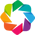

In [49]:
os.environ['HV_DOC_HTML'] = 'true'

'''The essential functionality'''

hv.extension('bokeh')
kwargs = dict(width=1000, height=1000, xaxis=None, yaxis=None)
hv.opts.defaults(hv.opts.Nodes(**kwargs), hv.opts.Graph(**kwargs))

# choose a NetworkX graphical layout 
pos = nx.spring_layout(G,k=0.15,iterations=20)  

# collect graph from NetworkX 
my_graph = hv.Graph.from_networkx(G, pos)

# bundle edges 
bundled = bundle_graph(my_graph)
bundled.opts(padding=0.1) 

# add community and in-degree features
bundled.opts(node_color=hv.dim('community'), node_size=((hv.dim('in_degree') + 1)*5), width=1000, 
                          cmap='Colorblind')
bundled.opts(inspection_policy='edges')

renderer = hv.renderer('bokeh')

display_html(renderer.static_html(bundled), raw=True)

# green connection if something is referencing it
# orange connection if it is referncing something 
# blue if title , dark blue if high degree, light blue if small degree 
# red if resource, dark red if high degree, light red if small degree

## 6. Saving and Next Steps

You can export your figure in *HTML* or *SVG* format using the following code:

In [0]:
# Using bokeh
hv.save(obj, 'plot.html', backend='bokeh')

# Using matplotlib
hv.save(obj, 'plot.svg', backend='matplotlib')

NameError: ignored

Furthermore, you can generate a graph from [live data](https://https://holoviews.org/user_guide/Live_Data.html) or [deploy Bokeh](http://holoviews.org/user_guide/Deploying_Bokeh_Apps.html) directly in apps.